In [1]:
import numpy as np
from os import listdir, makedirs
from os.path import isfile, join, dirname, realpath, isdir
import json
import re
import pandas as pd
import bbox
import matplotlib.pyplot as plt

In [2]:
def read_annotation(root_dir_name = "./output-annotation-Aug-28", user_list = ["Guilin", "Manoj", "Zuxin", "Mansur"]):
    matches = {}
    for user_name in user_list:
        matches.update({user_name:None})
    dir_list = listdir(root_dir_name)
    dir_list.sort()
    annotation_list = []
    for d in dir_list:
        m = re.match(r"(\d{3}).",d) # match the directory name
        if m:
            file_list = listdir( join(root_dir_name, d) )
            file_list.sort()
            for file in file_list:
                for user_name in matches:
                    matches[user_name] = re.match(user_name+r".(\d{4})(\d{6}).*" , file)
                    if matches[user_name]:
                        scene_num = matches[user_name].group(1)
                        frame_num = matches[user_name].group(2)
                        ID = scene_num+frame_num
                        frame_num = int(frame_num)
                        #print(user_name+" : "+ID)
                        with open( join(root_dir_name, d, file), "r") as read_file:
                            frames = json.load(read_file)['frame']["bounding_boxes"]
                        bbox_list = []
                        for frame in frames:
                            bbox_list.append({"width":frame["width"],"length":frame["length"],
                                              "height":frame["height"],"angle":frame["angle"],
                                             "object_id":frame["object_id"],"center":frame["center"],
                                              "timestamps":frame["timestamps"],"islocked":frame["islocked"]})
                        n_bbox = len(frames)
                        annotation_list.append([ID,scene_num,frame_num,user_name,bbox_list,n_bbox])
    df = pd.DataFrame(annotation_list,columns=['id','scene','frame','name','data','n_bbox'])
    return df

def read_annotation_bs(root_dir_name = "./output-annotation-Aug-28"):
    '''Read baseline data (the baseline file name is different with other annotation files)'''
    matches = {}
    matches.update({"baseline":None})
    dir_list = listdir(root_dir_name)
    dir_list.sort()
    annotation_list = []
    for d in dir_list:
        m = re.match(r"(\d{3}).",d) # match the directory name
        if m:
            file_list = listdir( join(root_dir_name, d) )
            file_list.sort()
            for file in file_list:
                for user_name in matches:
                    matches[user_name] = re.match(r"(\d{4})(\d{6}).*" , file)
                    if matches[user_name]:
                        scene_num = matches[user_name].group(1)
                        frame_num = matches[user_name].group(2)
                        ID = scene_num+frame_num
                        frame_num = int(frame_num)
                        #print(user_name+" : "+ID)
                        with open( join(root_dir_name, d, file), "r") as read_file:
                            frames = json.load(read_file)['frame']["bounding_boxes"]
                        bbox_list = []
                        for frame in frames:
                            bbox_list.append({"width":frame["width"],"length":frame["length"],
                                              "height":1,"angle":frame["angle"],
                                             "object_id":frame["object_id"],"center":frame["center"],
                                              "timestamps":frame["timestamps"],"islocked":True})
                        n_bbox = len(frames)
                        annotation_list.append([ID,scene_num,frame_num,user_name,bbox_list,n_bbox])
    df = pd.DataFrame(annotation_list,columns=['id','scene','frame','name','data','n_bbox'])
    return df

def compute_IOU_3d(df, name_list = ["Guilin","Zuxin"], object_id = "car"):
    '''
    The first name is assumed to be the ground truth annotator
    '''
    if len(name_list)!=2 or df[df.name==name_list[0]].empty or df[df.name==name_list[1]].empty:
        print("The user name list is not correct! It must contain two names")
    iou_list = []
    ids = df[df.name==name_list[0]].id
    for k in ids:
        frame_df = df[df.id==k]
        gt_df = frame_df[frame_df.name==name_list[0]]
        eval_df = frame_df[frame_df.name==name_list[1]]
        if eval_df.empty:
            continue
        bbox_gt_list = gt_df["data"].iloc[0]
        bbox_eval_list = eval_df["data"].iloc[0]
        for j in range(len(bbox_eval_list)):
            iou_tmp_list = []
            ev = bbox_eval_list[j]
            if ev["object_id"] != object_id:
                continue
            bbox_ev = bbox.BBox3D(ev["center"]["x"],ev["center"]["y"],ev["height"]/2, ev["length"],
                                ev["width"],ev["height"],euler_angles=[0,0,ev["angle"]],is_center=True)
            for i in range(len(bbox_gt_list)):
                gt = bbox_gt_list[i]
                if gt["object_id"] != object_id or not gt["islocked"]:
                    continue
                bbox_gt = bbox.BBox3D(gt["center"]["x"],gt["center"]["y"],gt["height"]/2, gt["length"],
                                    gt["width"],gt["height"],euler_angles=[0,0,gt["angle"]],is_center=True)
                iou_tmp_list.append(bbox.metrics.iou_3d(bbox_ev,bbox_gt))
            if len(iou_tmp_list):
                iou_list.append(max(iou_tmp_list))
    return iou_list

def compute_IOU_2d(df, name_list = ["Guilin","Zuxin"], object_id = "car"):
    '''
    The first name is assumed to be the ground truth annotator
    The only difference with compute_IOU_3d is here I assume all the bboxes have same height
    '''
    if len(name_list)!=2 or df[df.name==name_list[0]].empty or df[df.name==name_list[1]].empty:
        print("The user name list is not correct! It must contain two names")
    iou_list = []
    ids = df[df.name==name_list[0]].id
    for k in ids:
        frame_df = df[df.id==k]
        gt_df = frame_df[frame_df.name==name_list[0]]
        eval_df = frame_df[frame_df.name==name_list[1]]
        if eval_df.empty:
            continue
        bbox_gt_list = gt_df["data"].iloc[0]
        bbox_eval_list = eval_df["data"].iloc[0]
        for j in range(len(bbox_eval_list)):
            iou_tmp_list = []
            ev = bbox_eval_list[j]
            if ev["object_id"] != object_id:
                continue
            bbox_ev = bbox.BBox3D(ev["center"]["x"],ev["center"]["y"],0, ev["length"],
                                ev["width"],1,euler_angles=[0,0,ev["angle"]],is_center=True)
            for i in range(len(bbox_gt_list)):
                gt = bbox_gt_list[i]
                if gt["object_id"] != object_id or not gt["islocked"]:
                    continue
                bbox_gt = bbox.BBox3D(gt["center"]["x"],gt["center"]["y"],0, gt["length"],
                                    gt["width"],1,euler_angles=[0,0,gt["angle"]],is_center=True)
                iou_tmp_list.append(bbox.metrics.iou_3d(bbox_ev,bbox_gt))
            if len(iou_tmp_list):
                iou_list.append(max(iou_tmp_list))
    return iou_list

def time_filter_for_frame(times_list, max_time = 3600):
    steps = len(times_list)
    for i in range(steps):
        idx = steps - i -1
        if idx<1:
            print("seems no feasible timestamps for the first timestamp?")
        t = (times_list[idx] - times_list[0])/1000.0
        if t > 0.01 and t < max_time:
            return t
    print("something wrong")
    return None
def compute_time(df, name = "Guilin", object_id = "all", max_time = 2000):
    '''
    object_id : 'all' or 'car' or 'pedestrian'
    max time is to filter the frame time which above max_time
    '''
    if df[df.name==name].empty:
        print("The user name list is not correct! It must contain two names")
    eval_df = df[df.name==name]
    t_list = []
    for frame_num in range(len(eval_df)):
        bbox_list = eval_df.iloc[frame_num]["data"]
        times_list = []
        for bbox_data in bbox_list:
            if bbox_data["object_id"] == object_id or object_id == "all":
                times_list = times_list+bbox_data["timestamps"]
        if times_list==[]:
            continue
        times_list.sort()
        t_frame = time_filter_for_frame(times_list, max_time=max_time)
        t_list.append(t_frame)
    return t_list

In [3]:
df_eval = read_annotation(root_dir_name = "./output-annotation-Aug-28", user_list = ["Guilin", "Manoj", "Zuxin", "Mansur"])
df_eval.head()

,id,scene,frame,name,data,n_bbox
0,0020000000,0020,0,Guilin,"[{'width': 1.8009142585999458, 'length': 3.556...",28
1,0020000001,0020,1,Guilin,"[{'width': 3.764226128397707, 'length': 1.7874...",28
2,0020000002,0020,2,Guilin,"[{'width': 3.5560240209093017, 'length': 1.800...",24
3,0020000003,0020,3,Guilin,"[{'width': 3.5560240209093017, 'length': 1.800...",24
4,0020000004,0020,4,Guilin,"[{'width': 3.5560240209093017, 'length': 1.800...",25


In [4]:
df_base = read_annotation_bs(root_dir_name = "./output-annotation-baseline-Sep-9")
df_base.head()

,id,scene,frame,name,data,n_bbox
0,0020000000,0020,0,baseline,"[{'width': 5.146237182912088, 'length': 2.3106...",20
1,0020000001,0020,1,baseline,"[{'width': 6.038276671924052, 'length': 2.6354...",19
2,0020000002,0020,2,baseline,"[{'width': 6.134837842146576, 'length': 2.9165...",20
3,0020000003,0020,3,baseline,"[{'width': 5.259288637915006, 'length': 2.3117...",15
4,0020000004,0020,4,baseline,"[{'width': 5.791629166460211, 'length': 2.6417...",15


seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
seems no feasible timestamps for the first timestamp?
something wrong
Guilin time(s) :  38028.293999999994
Zuxin time(s) :  3381.3250000000007
Mansur time(s) :  18105.406
Manoj time(s) :  3542.0560000000005
baseline time(s) :  10865.687999999993


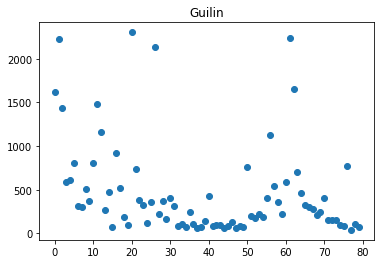

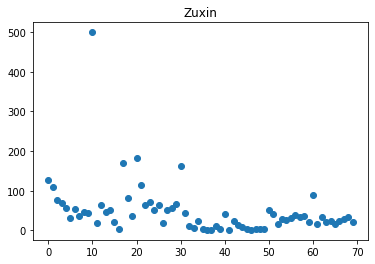

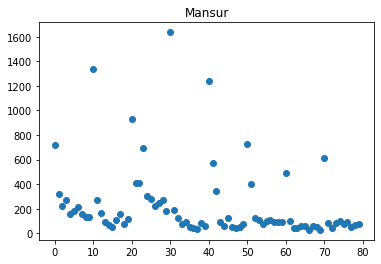

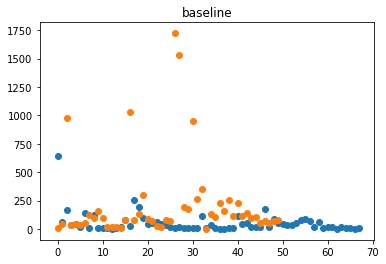

In [5]:
t_list_z = compute_time(df_eval, name = "Zuxin", object_id = "all", max_time = 2400)
t_list_g = compute_time(df_eval, name = "Guilin", object_id = "all", max_time = 2400)
t_list_m1 = compute_time(df_eval, name = "Mansur", object_id = "all",max_time = 2400)
t_list_m2 = compute_time(df_eval, name = "Manoj", object_id = "all",max_time = 2400)
t_list_b = compute_time(df_base, name = "baseline", object_id = "all",max_time = 2400)
print("Guilin time(s) : ",sum(t_list_g))
print("Zuxin time(s) : ",sum(t_list_z))
print("Mansur time(s) : ",sum(t_list_m1))
t_list_m2= list(filter(None, t_list_m2))
sum(t_list_m2)
print("Manoj time(s) : ",sum(t_list_m2))
t_list_b= list(filter(None, t_list_b))
print("baseline time(s) : ",sum(t_list_b))

plt.scatter(np.arange(len(t_list_g)),t_list_g)
plt.title("Guilin Time")
plt.show()
plt.scatter(np.arange(len(t_list_z)),t_list_z)
plt.title("Zuxin Time")
plt.show()
plt.scatter(np.arange(len(t_list_m1)),t_list_m1)
plt.title("Mansur Time")
plt.show()
plt.scatter(np.arange(len(t_list_m2)),t_list_m2)
plt.title("Manoj Time")
plt.scatter(np.arange(len(t_list_b)),t_list_b)
plt.title("baseline Time")
plt.show()

In [6]:
df_comb = pd.concat([df_eval,df_base])
df_comb.head()

,id,scene,frame,name,data,n_bbox
0,0020000000,0020,0,Guilin,"[{'width': 1.8009142585999458, 'length': 3.556...",28
1,0020000001,0020,1,Guilin,"[{'width': 3.764226128397707, 'length': 1.7874...",28
2,0020000002,0020,2,Guilin,"[{'width': 3.5560240209093017, 'length': 1.800...",24
3,0020000003,0020,3,Guilin,"[{'width': 3.5560240209093017, 'length': 1.800...",24
4,0020000004,0020,4,Guilin,"[{'width': 3.5560240209093017, 'length': 1.800...",25


In [7]:
iou_list_baseline = compute_IOU_2d(df_comb,name_list=["Guilin","baseline"])


print(" 2D IOU")
print("results without filtering")
print("baseline : ",np.mean(iou_list_baseline))

print("after filtering")
old_list = iou_list_baseline
new_list = []
thres = 0.5
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean baseline: ", np.mean(new_list))

 2D IOU
results without filtering
baseline :  0.6166499120234604
after filtering
mean baseline:  0.7785809885931558


In [8]:
iou_list_zuxin = compute_IOU_2d(df_eval,name_list=["Guilin","Zuxin"])
iou_list_mansur = compute_IOU_2d(df_eval,name_list=["Guilin","Mansur"])
iou_list_manoj = compute_IOU_2d(df_eval,name_list=["Guilin","Manoj"])

print(" 2D IOU")
print("results without filtering")
print("zuxin : ",np.mean(iou_list_zuxin))
print("mansur : ",np.mean(iou_list_mansur))
print("manoj : ",np.mean(iou_list_manoj))

print("after filtering")

thres = 0.5
old_list = iou_list_zuxin
new_list = []
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean zuxin: ", np.mean(new_list))

old_list = iou_list_mansur
new_list = []
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean mansur: ", np.mean(new_list))

old_list = iou_list_manoj
new_list = []
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean manoj: ", np.mean(new_list))

 2D IOU
results without filtering
zuxin :  0.6995209841827768
mansur :  0.6823312556053811
manoj :  0.5852009409888357
after filtering
mean zuxin:  0.7992253703703703
mean mansur:  0.8469733333333334
mean manoj:  0.7744887804878049


In [ ]:
def read_kitti_label(kitti_root_dir = "./kitti_label"):
    files = listdir(kitti_root_dir)
    files.sort()
    df_kitti = pd.DataFrame()
    for file in files:
        with open(join(kitti_root_dir,file)) as f:
            kitti_frames = f.read().split('\n')
            kitti_list = []
            for frame in kitti_frames:
                if frame=='':
                    continue
                kitti_list.append(frame.split(" "))
            df = pd.DataFrame(kitti_list, columns=['frame_id', 'obj_id', 'type', 'truncated', 'occluded'
                                                     , 'alpha', 'b1', 'b2', 'b3', 'b4', 'h', 'w', 'l', 'x', 'y', 
                                                    'z', 'yaw'])
            df['scene_num'] = file.split('.')[0]
            df_kitti = pd.concat([df_all,df])
    df_kitti['frame_id'] = df_kitti['frame_id'].astype(int)
    df_kitti['yaw'] = df_kitti['yaw'].astype(float)
    return df_kitti

def compute_iou2d_with_kitti(df_kitti, df_eval, name="Guilin", object_id="car"):
    df_eval = df_eval[df_eval["name"]==name]
    if df_eval.empty:
        print("No such user name")
    iou_list = []
    for i in range(len(df_eval)):
        scene_num = df_eval.iloc[i]["scene"]
        frame_id = df_eval.iloc[i]["frame"]
        bbox_eval_list = df_eval.iloc[i]["data"]
        df_kitti_match = df_kitti[(df_kitti["scene_num"]==scene_num) & (df_kitti["frame_id"]==frame_id)]
        for j in range(len(bbox_eval_list)):
            iou_tmp_list = []
            ev = bbox_eval_list[j]
            if ev["object_id"] != object_id and ev["object_id"] != object_id.capitalize():
                continue
            bbox_ev = bbox.BBox3D(ev["center"]["x"],ev["center"]["y"],0, ev["length"],
                                ev["width"],1,euler_angles=[0,0,ev["angle"]],is_center=True)
            for k in range(len(df_kitti_match)):
                gt = df_kitti_match.iloc[k]
             #   if gt["type"] != object_id.capitalize() and gt["type"] != object_id:
             #       continue
                bbox_gt = bbox.BBox3D(float(gt["x"]),float(gt["y"]),0, float(gt["l"]),
                                    float(gt["w"]),1 ,euler_angles=[0,0,gt["yaw"]],is_center=True)
                iou_tmp_list.append(bbox.metrics.iou_3d(bbox_ev,bbox_gt))
            if len(iou_tmp_list):
                iou_list.append(max(iou_tmp_list))
    return iou_list

df_kitti = read_kitti_label(kitti_root_dir = "./kitti_label")
df_kitti.head()

iou_list_zuxin = compute_iou2d_with_kitti(df_kitti, df_eval, name="Zuxin", object_id="car")
iou_list_manoj = compute_iou2d_with_kitti(df_kitti, df_eval, name="Manoj", object_id="car")
iou_list_guilin = compute_iou2d_with_kitti(df_kitti, df_eval, name="Guilin", object_id="car")
iou_list_mansur = compute_iou2d_with_kitti(df_kitti, df_eval, name="Mansur", object_id="car")


print(" 2D IOU")
print("results without filtering")
print("zuxin : ",np.mean(iou_list_zuxin))
print("mansur : ",np.mean(iou_list_mansur))
print("manoj : ",np.mean(iou_list_manoj))
print("guilin : ",np.mean(iou_list_guilin))

print("after filtering")
thres = 0.5
old_list = iou_list_zuxin
new_list = []
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean zuxin: ", np.mean(new_list))

old_list = iou_list_mansur
new_list = []
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean mansur: ", np.mean(new_list))

old_list = iou_list_manoj
new_list = []
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean manoj: ", np.mean(new_list))

old_list = iou_list_guilin
new_list = []
for i in range(len(old_list)):
    if old_list[i]>thres:
        new_list.append(old_list[i])
print("mean guilin: ", np.mean(new_list))